#### Cone Intersect

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from multiprocessing import Pool

One helper function: 

From a 3D index $[i,j,k]$ with $i,j,k\in[0,\dots,N-1]$ we can form a bijective 1D index 
$$
\varphi([i,j,k]) = i + N \cdot (j + N \cdot k).
$$

For instance, consider a $3\times 3 \times 3$ cube with index $\{[i,j,k]|i,j,k\in [0,1,2]\}$ then 

$$
\varphi([i,j,k]) = i+3\cdot j + 9\cdot k
$$

| $\varphi([i,j,k])$ | $i$ | $j$ | $k$| $|$ $\varphi([i,j,k])$ | $i$ | $j$ | $k$|
| ----------- | ----------- |----|-----| -- | -- |-- |-- |
|0|0|0|0|14|2|1|1|
|1|1|0|0|15|0|2|1|
|2|2|0|0|16|1|2|1|
|3|0|1|0|17|2|2|1|
|4|1|1|0|18|0|2|2|
|5|2|1|0|19|1|2|2|
|6|0|2|0|20|2|2|2|
|7|1|2|0|21|0|2|2|
|8|2|2|0|22|1|2|2|
|9|0|0|1|23|2|2|2|
|10|1|0|1|24|0|2|2|
|11|2|0|1|25|1|2|2|
|12|0|1|1|26|2|2|2|
|13|1|1|1|



the inverse is obtained through the algoritm 

$$
\begin{aligned}
\varphi^{-1}(n) &:\\
k &= \text{floor}\left\{\frac{n}{N^2}\right\}\\
    n &\leftarrow n-k\cdot N^2\\
    j &= \text{floor}\left(\frac{n}{N}\right)\\
    i &\equiv n ~~\text{mod}~~N\\
    \Longrightarrow &[i,j,k]
\end{aligned}
$$

For instance considering the case anove for $N=3$ and $n=10$ we have 
$$
\begin{aligned}
\varphi^{-1}(10) &:\\
k &= \text{floor}\left\{\frac{10}{3^2}\right\}=1\\
    n &\leftarrow 10-1\cdot 3^2=1\\
    j &= \text{floor}\left(\frac{1}{10}\right)=0\\
    i &\equiv 1 ~~\text{mod}~~10 = 1\\
    \Longrightarrow& [1,0,1]
\end{aligned}
$$

In [52]:
def to1D(coordinates,dimensions):
  x,y,z=coordinates
  xMax,yMax,zMax=dimensions
  return (z * xMax * yMax) + (y * xMax) + x

def to3D(index,dimensions):
    xMax,yMax,zMax=dimensions
    z = index // (xMax * yMax)
    index -= (z * xMax * yMax)
    y = index // xMax
    x = index % xMax
    return x, y, z 

In [5]:
dimensions = [3,3,3]
xMax,yMax,zMax=dimensions
coordinates = [[i,j,k] for k in range(xMax) for j in range(yMax) for i in range(zMax)]
phi = []
print("phi | i,j,k")
for coord in coordinates: 
    n = to1D(coord,dimensions)
    print(n,"  ",coord)
    phi.append(n)

print("n| phi^-1")
for n in phi:
    i,j,k = to3D(n,dimensions)
    print(n,"   ",[i,j,k])

phi | i,j,k
0    [0, 0, 0]
1    [1, 0, 0]
2    [2, 0, 0]
3    [0, 1, 0]
4    [1, 1, 0]
5    [2, 1, 0]
6    [0, 2, 0]
7    [1, 2, 0]
8    [2, 2, 0]
9    [0, 0, 1]
10    [1, 0, 1]
11    [2, 0, 1]
12    [0, 1, 1]
13    [1, 1, 1]
14    [2, 1, 1]
15    [0, 2, 1]
16    [1, 2, 1]
17    [2, 2, 1]
18    [0, 0, 2]
19    [1, 0, 2]
20    [2, 0, 2]
21    [0, 1, 2]
22    [1, 1, 2]
23    [2, 1, 2]
24    [0, 2, 2]
25    [1, 2, 2]
26    [2, 2, 2]
n| phi^-1
0     [0, 0, 0]
1     [1, 0, 0]
2     [2, 0, 0]
3     [0, 1, 0]
4     [1, 1, 0]
5     [2, 1, 0]
6     [0, 2, 0]
7     [1, 2, 0]
8     [2, 2, 0]
9     [0, 0, 1]
10     [1, 0, 1]
11     [2, 0, 1]
12     [0, 1, 1]
13     [1, 1, 1]
14     [2, 1, 1]
15     [0, 2, 1]
16     [1, 2, 1]
17     [2, 2, 1]
18     [0, 0, 2]
19     [1, 0, 2]
20     [2, 0, 2]
21     [0, 1, 2]
22     [1, 1, 2]
23     [2, 1, 2]
24     [0, 2, 2]
25     [1, 2, 2]
26     [2, 2, 2]


We first define a computational domain that specifies the extent of the volume in which to reconstruct the intensity distribution and discretizes this volume into voxels. First, lets create a discretized world.

In [29]:
dim = [150,150,150]
side_length = 80
dX,dY,dZ = dim
positions_world = [(np.array([(i+0.5)/dX,(j+0.5)/dY,(k+0.5)/dZ]))*side_length-side_length/2 * np.array([1,1,0])
                   for k in range(dX) for j in range(dY) for i in range(dZ)]

Noticed that I've put voxel $v_0$ in the corner $(-49.5,-49.5,0)$ and the last voxel $v_{99999}$ in the upper corner $(49.5,49.5,99.5)$. All in the center of the voxels.

Now, lets put a cube with sidelengths $10$ and center at $(0,0,50)$ in to the world.

In [30]:
def square_phantom(r0,l,dim,positions):
    '''
    Parameters: 
        r0 is the center of the sphere relative to origin which is assumed to be in the middle.
        l the sidelength of the square
        N is the number of voxels along one dimension, it is the same for the remaining two. 
    Returns: 
        numpy.array with shape (N,N,N) with 0 or 1 in each element. 1 if that voxel is contained within the sphere, 0 otherwise.
    '''
    dX,dY,dX = dim
    out = np.zeros((dX,dY,dZ))
    
    for i in range(dX):
        for j in range(dY):
            for k in range(dZ):
                n = to1D([i,j,k],dim)
                [x,y,z] = positions[n]
                x = -x
                if np.abs(x-r0[0])**2+np.abs(y-r0[1])**2 + np.abs(z-r0[2])**2 <l**2:
                    out[i][j][k] = 1

    return out

In [54]:
r0 = [-10,0,10]
l = 10
world = square_phantom(r0,l,dim,positions_world)


In [55]:

pixel_length = side_length/dim[0]

z_height = int(r0[2]/pixel_length)
pixel_cube_Z_start = int( z_height - 1)
pixel_cube_Z_end = int( z_height -1 + 2*l/pixel_length + 1)

slice = np.array(world[:,:,int( (pixel_cube_Z_end-pixel_cube_Z_start)/2 )])

indices = np.where(slice == 1)
pixel_cube_X_start = min(indices[0])
pixel_cube_X_end = max(indices[0])
pixel_cube_Y_start = min(indices[1])
pixel_cube_Y_end = max(indices[1])




print(pixel_cube_X_start,pixel_cube_X_end)
print(pixel_cube_Y_start,pixel_cube_Y_end)
print(pixel_cube_Z_start,pixel_cube_Z_end)

75 111
56 93
17 55


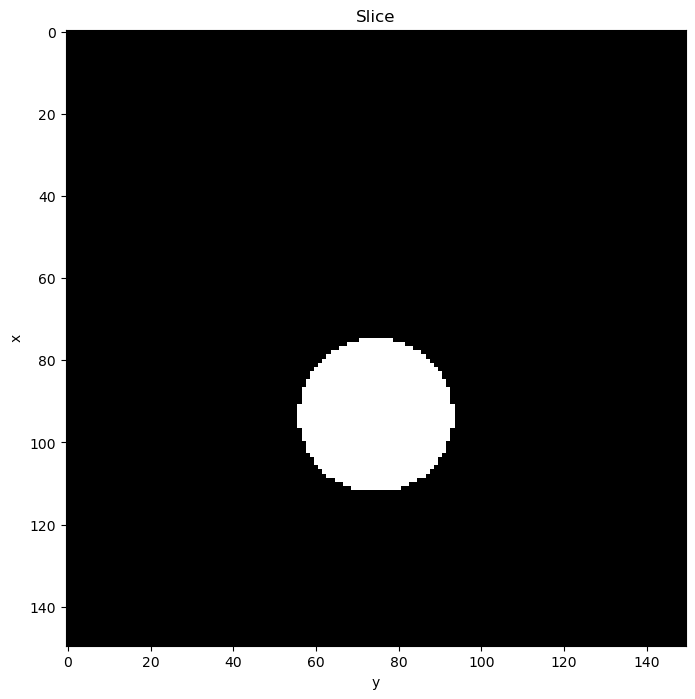

In [56]:
image = slice
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
ax1.set_xlabel("y")
ax1.set_ylabel("x")
ax1.set_title("Slice")
ax1.imshow(
    image,
    cmap=plt.cm.Greys_r,
    aspect='auto'#,
    #extent =[-49.5,49.5, -49.5, 49.5]
)



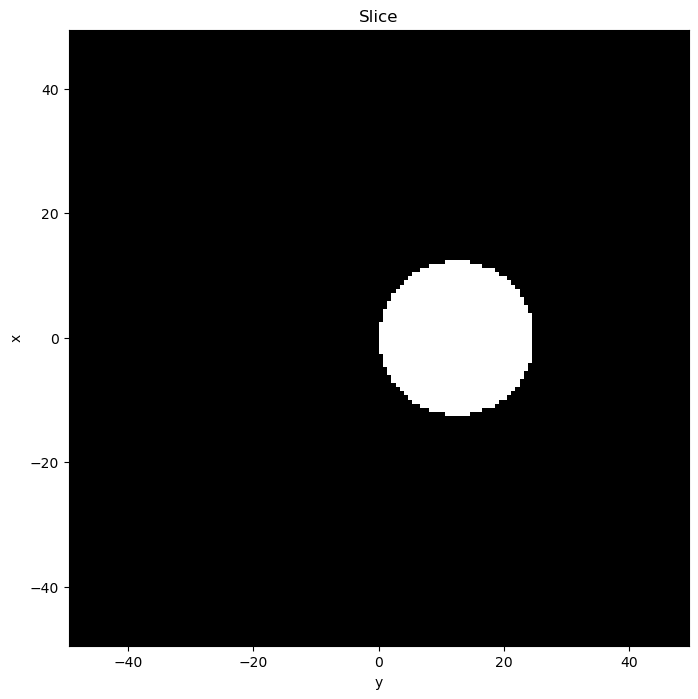

In [57]:
img_rot = (ndimage.rotate(image, 90,reshape = False))**2
img_rot[img_rot>0.5] = 1
img_rot[img_rot<0.5] = 0
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
ax1.set_xlabel("y")
ax1.set_ylabel("x")
ax1.set_title("Slice")
ax1.imshow(
    img_rot,
    cmap=plt.cm.Greys_r,
    aspect='auto',
    extent =[-49.5,49.5, -49.5, 49.5]
)

Above is a slice at the center of the cube parallell to the $xy$-plane.

## Cone projections
Consider now a cone, defined by an axis $\beta$, half-angle $\phi$, and position $\mathbf{r}_s$. Let $\beta=[0,0,1]$ and $\phi=\pi/4$ and $\mathbf{r}_s$ be on a grid of square $11\times 1$ 'detectors' on the $x$-axis evenly spaced.

In [62]:
beta = np.array([0,0,1])
phi = np.pi/4
num_det = 11
rs = [(-side_length/2)*np.array([1,0,0]) + np.array([i,0,0])*(side_length)/(num_det-1) for i in range(num_det)]


No define the zero-level set function:

In [64]:
def g(x,r,beta,phi):
    v = x-r
    norm_v = np.linalg.norm(v)
    return np.sign(np.dot(v/norm_v,beta)-np.cos(phi))

Now, the indicator function can be constructed.

In [66]:
def I(vj,r,beta,phi,side_length,dim):
    dx,dy,dz = np.array([side_length/dim[0],side_length/dim[1],side_length/dim[2]])
    #Corners

    w1 = g(vj + np.array([dx,dy,dz]),r,beta,phi)
    w2 = g(vj + np.array([-dx,dy,dz]),r,beta,phi)
    w3 = g(vj + np.array([dx,-dy,dz]),r,beta,phi)
    w4 = g(vj + np.array([-dx,-dy,dz]),r,beta,phi)
    w5 = g(vj + np.array([dx,dy,-dz]),r,beta,phi)
    w6 = g(vj + np.array([-dx,dy,-dz]),r,beta,phi)
    w7 = g(vj + np.array([dx,-dy,-dz]),r,beta,phi)
    w8 = g(vj + np.array([-dx,-dy,-dz]),r,beta,phi)

    return (np.abs(w1+w2+w3+w4+w5+w6+w7+w8) == \
                np.abs(w1)+np.abs(w2)+np.abs(w3)+np.abs(w4)+np.abs(w5)+np.abs(w6)+np.abs(w7)+np.abs(w8))
    
    

In [ ]:

thetas = np.linspace(0,180,10,endpoint=False)
sinogram = np.zeros((len(thetas),len(rs)))

for i_theta, theta in enumerate(thetas):

    cone_surface_projection = np.zeros(len(rs))
    
    for index_r,r_i in enumerate(rs):
        #print(index_r)
        
        for k in range(pixel_cube_Z_start-3,pixel_cube_Z_end+3):
            plane = world[:,:,k]
            world_plane_theta = ndimage.rotate(plane, theta,reshape = False)
            world_plane_theta[world_plane_theta>0.5] = 1
            world_plane_theta[world_plane_theta<0.5] = 0
            for i in range(pixel_cube_X_start,pixel_cube_X_end):
                for j in range(pixel_cube_Y_start,pixel_cube_Y_end):
                    n = to1D([i,j,k],dim)
                    [x,y,z] = positions_world[n]
                    x = -x
                    pos = np.array([x,y,z])
                    if I(pos,r_i,beta,phi,side_length,dim):
                        cone_surface_projection[index_r] += world_plane_theta[i,j]
        sinogram[i_theta,:] = cone_surface_projection
    print(i_theta/len(thetas+ index_r/num_det/10))




0.0


In [68]:

def cone_surface_proj(theta):
    cone_surface_projection = np.zeros(len(rs))
    
    for index_r,r_i in enumerate(rs):
        #print(index_r)
        
        for k in range(pixel_cube_Z_start-3,pixel_cube_Z_end+3):
            plane = world[:,:,k]
            world_plane_theta = ndimage.rotate(plane, theta,reshape = False)
            world_plane_theta[world_plane_theta>0.5] = 1
            world_plane_theta[world_plane_theta<0.5] = 0
            for i in range(pixel_cube_X_start,pixel_cube_X_end):
                for j in range(pixel_cube_Y_start,pixel_cube_Y_end):
                    n = to1D([i,j,k],dim)
                    [x,y,z] = positions_world[n]
                    x = -x
                    pos = np.array([x,y,z])
                    if I(pos,r_i,beta,phi,side_length,dim):
                        cone_surface_projection[index_r] += world_plane_theta[i,j]
    return cone_surface_projection


NameError: name 'sinogram' is not defined

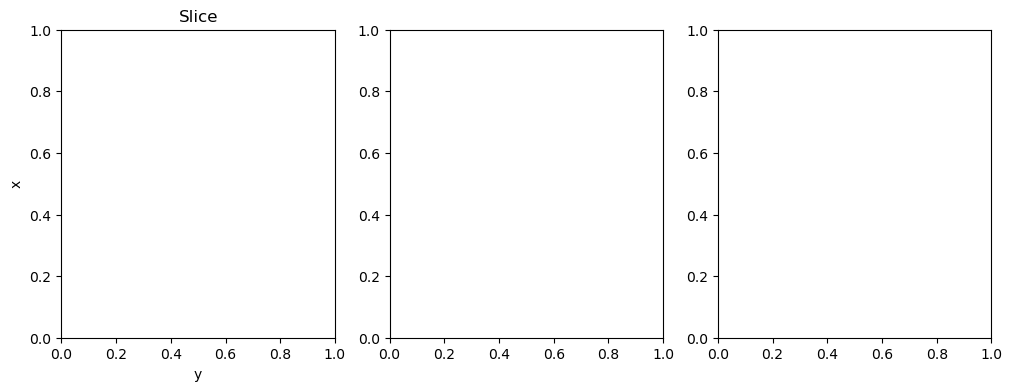

In [44]:

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,4 ))
ax1.set_xlabel("y")
ax1.set_ylabel("x")
ax1.set_title("Slice")
ax1.imshow(
    sinogram,
    cmap=plt.cm.Greys_r,
    aspect='auto'
)

In [ ]:
if __name__ == "__main__":
    thetas = np.linspace(0,180,10,endpoint=False)
    with Pool() as pool:
      result = pool.map(cone_surface_proj, thetas)

In [ ]:
result.shape